In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf



In [9]:
import pandas as pd

demo = pd.read_sas("/content/DEMO_L.xpt", format="xport")
bpx  = pd.read_sas("/content/BPXO_L.xpt", format="xport")
paq  = pd.read_sas("/content/PAQ_L.xpt", format="xport")
bmx  = pd.read_sas("/content/BMX_L.xpt", format="xport")
vid  = pd.read_sas("/content/VID_L.xpt", format="xport")
hepb = pd.read_sas("/content/HEPB_S_L.xpt", format="xport")
kiq  = pd.read_sas("/content/KIQ_U_L.xpt", format="xport")
whq = pd.read_sas("/content/WHQ_L.xpt", format="xport")


df = demo.merge(bpx, on="SEQN", how="left") \
         .merge(paq, on="SEQN", how="left") \
         .merge(bmx, on="SEQN", how="left") \
         .merge(vid, on="SEQN", how="left") \
         .merge(hepb, on="SEQN", how="left") \
         .merge(kiq, on="SEQN", how="left") \
         .merge(whq, on="SEQN", how="left")


df.shape



(11933, 89)

In [10]:
df[["SEQN","DMDMARTZ","DMDEDUC2","RIDAGEYR","BPXOSY3","BPXODI3","PAD680","WHD020","LBDVD2LC","LBXHBS","KIQ022"]].head()


,SEQN,DMDMARTZ,DMDEDUC2,RIDAGEYR,BPXOSY3,BPXODI3,PAD680,WHD020,LBDVD2LC,LBXHBS,KIQ022
0,130378.0,1.0,5.0,43.0,132.0,94.0,360.0,190.0,1.0,2.0,2.0
1,130379.0,1.0,5.0,66.0,113.0,76.0,480.0,220.0,1.0,2.0,2.0
2,130380.0,1.0,3.0,44.0,104.0,76.0,240.0,150.0,1.0,2.0,2.0
3,130381.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130382.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN


In [11]:
[col for col in df.columns if "WHD" in col]


['WHD010', 'WHD020', 'WHD050']

In [12]:
[col for col in df.columns if "WT" in col or "WEIGHT" in col.upper()]


['WTINT2YR', 'WTMEC2YR', 'BMXWT', 'BMIWT', 'WTPH2YR_x', 'WTPH2YR_y']

In [ ]:
  bmx.columns.tolist()


['SEQN',
 'BMDSTATS',
 'BMXWT',
 'BMIWT',
 'BMXRECUM',
 'BMIRECUM',
 'BMXHEAD',
 'BMIHEAD',
 'BMXHT',
 'BMIHT',
 'BMXBMI',
 'BMDBMIC',
 'BMXLEG',
 'BMILEG',
 'BMXARML',
 'BMIARML',
 'BMXARMC',
 'BMIARMC',
 'BMXWAIST',
 'BMIWAIST',
 'BMXHIP',
 'BMIHIP']

In [15]:
import numpy as np
import pandas as pd

def clean_continuous(series):
    s = pd.to_numeric(series, errors="coerce")
    return s.replace({7777: np.nan, 9999: np.nan})

# Clean continuous variables
df["PAD680_clean"] = clean_continuous(df["PAD680"])
df["WHD020_clean"] = clean_continuous(df["WHD020"])

df["RIDAGEYR"] = pd.to_numeric(df["RIDAGEYR"], errors="coerce")
df["BPXOSY3"]  = pd.to_numeric(df["BPXOSY3"], errors="coerce")
df["BPXODI3"]  = pd.to_numeric(df["BPXODI3"], errors="coerce")

# --- Marital status: Married vs NotMarried ---
dmd = pd.to_numeric(df["DMDMARTZ"], errors="coerce").replace({77: np.nan, 99: np.nan})
df["married_bin"] = pd.Series(np.nan, index=df.index, dtype="object")
df.loc[dmd == 1, "married_bin"] = "Married"
df.loc[dmd.isin([2,3,4,5,6]), "married_bin"] = "NotMarried"

# --- Education: BAplus vs LessThanBA ---
edu = pd.to_numeric(df["DMDEDUC2"], errors="coerce").replace({7: np.nan, 9: np.nan})
df["edu_bin"] = pd.Series(np.nan, index=df.index, dtype="object")
df.loc[edu == 5, "edu_bin"] = "BAplus"
df.loc[edu.isin([1,2,3,4]), "edu_bin"] = "LessThanBA"

# --- Kidney: Yes/No (optional) ---
kiq = pd.to_numeric(df["KIQ022"], errors="coerce").replace({7: np.nan, 9: np.nan})
df["kidney_bin"] = pd.Series(np.nan, index=df.index, dtype="object")
df.loc[kiq == 1, "kidney_bin"] = "Yes"
df.loc[kiq == 2, "kidney_bin"] = "No"

# Frequency checks (document in notebook)
print("Married counts:\n", df["married_bin"].value_counts(dropna=False))
print("\nEducation counts:\n", df["edu_bin"].value_counts(dropna=False))
print("\nKidney counts:\n", df["kidney_bin"].value_counts(dropna=False))


Married counts:
 married_bin
NaN           4150
Married       4136
NotMarried    3647
Name: count, dtype: int64

Education counts:
 edu_bin
LessThanBA    5158
NaN           4150
BAplus        2625
Name: count, dtype: int64

Kidney counts:
 kidney_bin
No     7473
NaN    4139
Yes     321
Name: count, dtype: int64


In [16]:
df[["married_bin","edu_bin","PAD680_clean","WHD020_clean"]].head()


,married_bin,edu_bin,PAD680_clean,WHD020_clean
0,Married,BAplus,360.0,190.0
1,Married,BAplus,480.0,220.0
2,Married,LessThanBA,240.0,150.0
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


In [17]:
# Q1 Code
# Is there an association between martital status (married or not married) and education level (bachelor's degreen or higher vs. less than a bachelor's degree)?
import pandas as pd
import numpy as np
from scipy import stats

# Subset to non-missing for both variables
q1 = df.dropna(subset=["married_bin", "edu_bin"]).copy()

# Contingency table
ct = pd.crosstab(q1["married_bin"], q1["edu_bin"])
print(ct)

# Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(ct)
print("\nChi-square:", chi2)
print("df:", dof)
print("p-value:", p)

# Effect size: Cramér's V
n = ct.to_numpy().sum()
r, k = ct.shape
cramers_v = np.sqrt((chi2 / n) / (min(r-1, k-1)))
print("Cramér's V:", cramers_v)


edu_bin      BAplus  LessThanBA
married_bin                    
Married        1631        2503
NotMarried      990        2648

Chi-square: 129.17381826322236
df: 1
p-value: 6.213197986632679e-30
Cramér's V: 0.12892016497672157


In [18]:
(ct.div(ct.sum(axis=1), axis=0) * 100).round(1)


edu_bin,BAplus,LessThanBA
married_bin,,
Married,39.5,60.5
NotMarried,27.2,72.8


Married mean (minutes): 353.28714076960546
Not married mean (minutes): 371.95753538717736
Sample sizes: 4106 3603
t-statistic: -3.8513937236357263
p-value: 0.0001184387220986923


/tmp/ipython-input-4104814738.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([married, not_married], labels=["Married", "Not Married"])


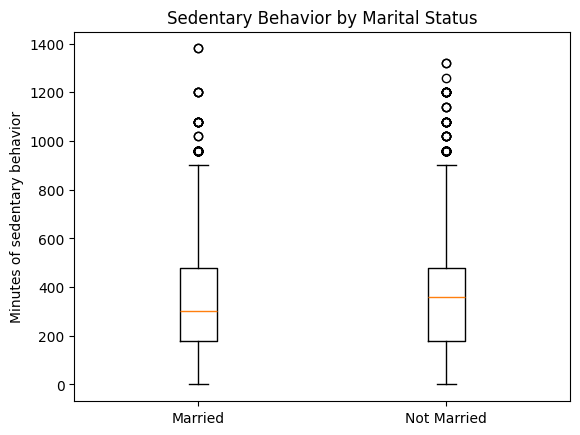

In [19]:
# Q2 Code
# Is there a difference in the mean sedentary behavior time between those who are married and those who are not married?
from scipy import stats
import matplotlib.pyplot as plt

# Subset to valid rows
q2 = df.dropna(subset=["married_bin", "PAD680_clean"]).copy()

# Split groups
married = q2.loc[q2["married_bin"] == "Married", "PAD680_clean"]
not_married = q2.loc[q2["married_bin"] == "NotMarried", "PAD680_clean"]

# Descriptives
print("Married mean (minutes):", married.mean())
print("Not married mean (minutes):", not_married.mean())
print("Sample sizes:", len(married), len(not_married))

# Welch's t-test
t_stat, p_val = stats.ttest_ind(married, not_married, equal_var=False)
print("t-statistic:", t_stat)
print("p-value:", p_val)

# Visualization
plt.figure()
plt.boxplot([married, not_married], labels=["Married", "Not Married"])
plt.ylabel("Minutes of sedentary behavior")
plt.title("Sedentary Behavior by Marital Status")
plt.show()


In [20]:
# Q3 Code
# How do age and marital status affect systolic blood pressure?
import statsmodels.formula.api as smf

# Subset to complete cases
q3 = df.dropna(subset=["RIDAGEYR", "BPXOSY3", "married_bin"]).copy()

# Convert marital status to numeric for regression
q3["married_01"] = q3["married_bin"].map({"Married": 1, "NotMarried": 0})

# Run linear regression
model = smf.ols("BPXOSY3 ~ RIDAGEYR + married_01", data=q3).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                BPXOSY3   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     453.3
Date:                Sun, 14 Dec 2025   Prob (F-statistic):          1.00e-183
Time:                        05:58:53   Log-Likelihood:                -24856.
No. Observations:                5838   AIC:                         4.972e+04
Df Residuals:                    5835   BIC:                         4.974e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    102.1600      0.764    133.758      0.000     100.663     103.657
RIDAGEYR       0.3952      0.013     30.105      0.000       0.369       0.421
married_01    -1.3420      0.451     -2.976      0.003      -2.226      -0.458
==============================================================================
Omnibus:                      685.805   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1454.643
Skew:                           0.726   Prob(JB):                         0.00
Kurtosis:                       4.967   Cond. No.                         196.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Pearson r: 0.1559714584645022
p-value: 1.6988498386823033e-44


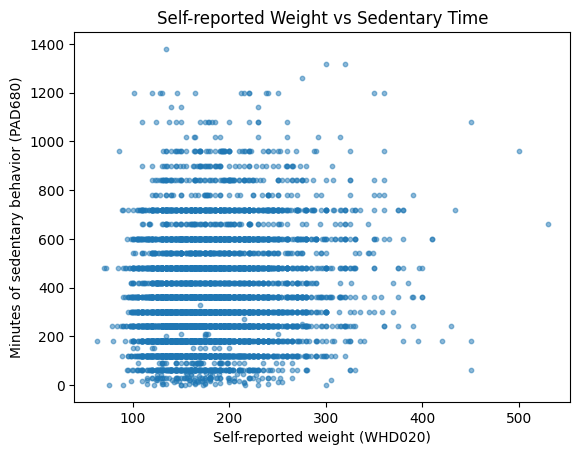

In [23]:
# Q4
# Is there a correlation between self-reported weight and minutes of sedentary behavior?
from scipy import stats
import matplotlib.pyplot as plt

# Subset to complete cases
q4 = df.dropna(subset=["WHD020_clean", "PAD680_clean"]).copy()

# Pearson correlation
r, p = stats.pearsonr(q4["WHD020_clean"], q4["PAD680_clean"])
print("Pearson r:", r)
print("p-value:", p)

# Scatterplot
plt.figure()
plt.scatter(q4["WHD020_clean"], q4["PAD680_clean"], s=10, alpha=0.5)
plt.xlabel("Self-reported weight (WHD020)")
plt.ylabel("Minutes of sedentary behavior (PAD680)")
plt.title("Self-reported Weight vs Sedentary Time")
plt.show()


In [24]:
## Q5
# Is there an association between marital status and reporting weak or failing kidneys?

from scipy import stats
import numpy as np
import pandas as pd

# Subset to valid rows
q5 = df.dropna(subset=["married_bin", "kidney_bin"]).copy()

# Contingency table
ct5 = pd.crosstab(q5["married_bin"], q5["kidney_bin"])
print(ct5)

# Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(ct5)
print("Chi-square:", chi2)
print("df:", dof)
print("p-value:", p)

# Effect size: Cramér's V
n = ct5.to_numpy().sum()
r, k = ct5.shape
cramers_v = np.sqrt((chi2 / n) / (min(r-1, k-1)))
print("Cramér's V:", cramers_v)


kidney_bin     No  Yes
married_bin           
Married      3988  143
NotMarried   3463  176
Chi-square: 8.943113134812418
df: 1
p-value: 0.0027851763996300863
Cramér's V: 0.03392609337118215
